# Project 3 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time 
from scipy import integrate
from scipy.integrate import solve_ivp

In [7]:
%pip install numba
from numba import jit


Note: you may need to restart the kernel to use updated packages.


### Introduction

In this project four numerical methods have some of their qualities measured, namely order of convergence, energy conservation and chaotic behavior through Poincaré mapping. The problem solved using these methods is the Hénon-Heiles model, a four dimensional system with the equations
$$
\begin{aligned}
    &q_1' = p_1 \\
    &q_2' = p_2 \\
    &p_1' =  -q_1(1+2q_2)\\
    &p_2' = -(q_2 + q_1^2 - q_2^2) \\
\end{aligned}
$$


### Methods
Implementing the four numerical methods, Shampine-Bogacki, Runge Kutta 4, Kahans and Störmer-Verlet from given formulas in the project description.

### Method A, Shampine-Bogacki

The first method used is Shampine-Bogacki, a Runge-Kutta method of order 3. It is defined by:<br>
$$
\begin{aligned}
    &F_1 = F(y_n) \\
    &F_2 = F(y_n + \frac{1}{2}hF_1) \\
    &F_3 = F(y_n + \frac{3}{4}hF_2) \\
    &y_{n+1} = y_n + h(\frac{2}{9}F_1 + \frac{1}{3}F_2 + \frac{4}{9}F_3)
\end{aligned}
$$

The function F() uses pass-by reference to define F1, F2, and F3 respectively, before the main functions uses these vectors to define $y_{n+1}$.


In [8]:
#Defining the main funciton F according to the Hénon-Heiles model. 
#This function is used both in Method A and Method B
@jit(nopython=True)
def F(y,F_vec):
    F_vec[0] = y[2]
    F_vec[1] = y[3]
    F_vec[2] = -y[0]*(1+2*y[1])
    F_vec[3] = -(y[1] + y[0]**2 - y[1]**2)
    #Pass by reference requires no return value

#Initial values given as q_{}
y0=np.array([0, 0.45, 0.1578501399, 0])  

In [9]:
#Seems to be a problem with this code only the first time it is run
#ValueError: No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special'
#Does not appear if one reruns the code
@jit(nopython=True)
def shampine(y0, h, F, t0, tEnd):
    n = np.int(np.round((tEnd-t0)/h))
    # Creating a matrix y_vec to fill with our results.
    y_vec = np.zeros((4,n+1))
    y_vec[:,0] = y0
    #Creating a matrix to use while calculating
    F_vec = np.zeros((3,4))
    t = t0
    for i in range(n):        #Iterating over all timesteps
        if (tEnd-t) < h:
            h = tEnd-t    #Making sure we reach and use the endpoint
        t+=h
        #method from project description:
        F(y_vec[:,i], F_vec[0,:]) #Changes F1 for all parameters
        F(y_vec[:,i] + (1/2)*h * F_vec[0,:], F_vec[1,:]) #Changes F2
        F(y_vec[:,i] + (3/4)*h * F_vec[1,:], F_vec[2,:]) #Changes F3
        y_vec[:,i+1] = y_vec[:,i] + h * ((2/9)*F_vec[0,:] + (1/3)*F_vec[1,:] + (4/9)*F_vec[2,:])
    return y_vec   #Returning a matrix where each column contains q1, q2, p1 and p2, in that order.

y = shampine(y0, 1/12, F, 0, 10)


### Method B, Kutta

Method B is a Kuttas method of order 4. It is given in the assignment, and is defined as:

$$
\begin{aligned}
    &F_1 = F(y_n) \\
    &F_2 = F(y_n + \frac{1}{2}hF_1) \\
    &F_3 = F(y_n + \frac{1}{2}hF_2) \\
    &F_4 = F(y_n + hF_3) \\
    &y_{n+1} = y_n + h(\frac{1}{6}F_1 + \frac{1}{3}F_2 + \frac{1}{3}F_3 + \frac{1}{6}F_4)
\end{aligned}
$$
It is similar to Method A, and uses the same function F(), but has a higher order.

In [10]:
#print(np.zeros((4,4)))

@jit(nopython=True)
def kutta4(y0, h, F, t0, tEnd):
    n = np.int(np.round((tEnd-t0)/h))
    y_vec = np.zeros((4,n+1))     # Creating a matrix y_vec to fill with our results.
    y_vec[:,0] = y0
    F_vec = np.zeros((4,4))   #Creating a matrix to use while calculating
    t = t0
    # iterating over all timesteps
    for i in range(n):
        if (tEnd-t) < h:
            h = tEnd-t    #Making sure we reach and use the endpoint
        t+=h
        #Method from project description
        F(y_vec[:,i], F_vec[0,:])
        F(y_vec[:,i] + (1/2)*h * F_vec[0,:], F_vec[1,:])
        F(y_vec[:,i] + (1/2)*h * F_vec[1,:], F_vec[2,:])
        F(y_vec[:,i] + h* F_vec[2,:], F_vec[3,:])
        y_vec[:,i+1] = y_vec[:,i] + h * ((1/6)*F_vec[0,:] + (1/3)*F_vec[1,:] + (1/3)*F_vec[2,:] + (1/6)*F_vec[3,:])
    return y_vec     #Returning a matrix where each column contains q1, q2, p1 and p2, in that order.

y = kutta4(np.array([0, 0.45, 0.1, 0]), 1/12, F, 0, 10)


### Metode C, Kahan



Kahan's method of order 2 is an implicit method of solving differential equations with a quadratic right-hand side. For this problem, it is defined as <br>
$$
\begin{aligned}
    &\frac{y_{i,n+1} - y_{i,n}}{h} = \sum_{j,k=1}^{4}a_{ijk}  \frac{y_{j,n}y_{k,n+1} + y_{j,n+1}y_{k,n}}{2} + \sum_{j=1}^{4}b_{ij} \frac{y_{j,n}+y_{j,n+1}}{2}. 
\end{aligned}
$$

First one has to define the coefficients of the right-hand side, using the defenition:
$$
\begin{aligned}
    &y_i' = \sum_{j,k=1}^{4}a_{ijk}y_jy_k + \sum_{j=1}^{4}b_{ij}y_j + c_i. 
\end{aligned}
$$
Using the given equations, the coefficients for the different parameters were found to be mostly zeros, with the exceptions of: <br>
$$
\begin{aligned}
    &q_{1}': b_{13}= 1 \\
    &q_{2}': b_{24} = 1 \\
    &p_{1}': a_{312} = -2, b_{31}= -1 \\
    &p_{2}': a_{411} = -1, a_{422}= 1, b_{42} = -1 \\
\end{aligned}
$$
After finding the parameters, Kahan's method is used to define a set of differential equations <br>

$$\begin{bmatrix} 1 & 0 & -\frac{h}{2} & 0 \\ 0 & 1 & 0 &-\frac{h}{2} \\ h(\frac{1}{2} + q_{2,n}) & hq_{1,n} & 1 & 0 \\ hq_{1,n} & h(\frac{1}{2} - q_{2,n}) & 0 & 1 \end{bmatrix}  \begin{bmatrix} q_{1,n+1} \\q_{2,n+1} \\ p_{1,n+1} \\ p_{2,n+1} \end{bmatrix} = \begin{bmatrix} q_{1,n} + \frac{h}{2}p_{1,n} \\ q_{2,n} + \frac{h}{2}p_{2,n} \\ p_{1,n} - \frac{h}{2}q_{1,n} \\ p_{2,n} - \frac{h}{2}q_{2,n}\end{bmatrix}$$

Which is then solved for each time-step using numpy.linalg.solve()


The function kahansF() uses pass-by reference to change the rows of matrix A and the values of vector b respectively for each timestep. <br>
Further, the method of iterating through time is used in a similar way as in method A and B. The next timestep of $q_1$, $q_2$, $p_1$ and $p_2$ is defined by the matrix above, and the vector y is returned.


 

In [11]:
@jit(nopython = True)
def kahansF(y_vec, A, b,h):
    #Setting the rows of A, and the values of b
    #respectively for each Time-step.
    A[2] = [h*(y_vec[1]+1/2), h*y_vec[0], 1, 0]
    A[3] = [h*y_vec[0], h*(1/2 - y_vec[1]), 0, 1]
    b[0] = y_vec[0] + y_vec[2]*h/2
    b[1] = y_vec[1]+ y_vec[3]*h/2
    b[2] = y_vec[2]-y_vec[0]*h/2
    b[3] = y_vec[3]-y_vec[1]*h/2
    #Pass-by reference requires no return value.

@jit(nopython = True)
def kahans(y0, h, f, t0, tEnd):
    n = np.int(np.round((tEnd-t0)/h))    #Setting the amount of timesteps
    y = np.ones(shape = (4,n+1))         #Defining y as a vector for each timestep
    y[:,0] = y0
    A = np.zeros((4,4))
    A[0] = [1, 0, -h/2, 0]
    A[1] = [0, 1, 0, -h/2]               #Creating the matrix
    b = np.zeros(4)
    t = t0
    for i in range(n):
        if (tEnd-t) < h:
            h = tEnd-t                #Making sure we reach and use the endpoint
            A[0] = [1, 0, -h/2, 0]
            A[1] = [0, 1, 0, -h/2]
        t += h
        tNext= t+h
        f(y[:,i], A, b,h) #Pass-by reference changes values of A and b
        y[:, i+1] = np.linalg.solve(A, b) #Returns the solution to A*x = b
    return y

y = kahans(np.array([0,0.45,0.1,0]), 10**(-3), kahansF, 0, 10)

### Method D, Störmer-Verlet

Our last numerical method is the Störmer-Verlet method of second order which is defined by $q''=F(q)$. We see that $F$ only relies on $q$. This makes for an effective numerical solution; 
$$
\begin{aligned}
    &p_{n+\frac{1}{2}} = p_n + \frac{1}{2} hf(q_n) \\  
    &q_{n+1}= q_n + \frac{1}{2} h p_{n+\frac{1}{2}} \\  
    &p_{n+1} = p_{n+\frac{1}{2}} + \frac{1}{2} hf(q_{n+1}) \\  
\end{aligned}
$$

In [12]:
%time
@jit(nopython = True)
def fStormer(q, fvec):
    fvec[0] = -q[0]*(1+2*q[1])
    fvec[1] = -(q[1] + q[0]**2 - q[1]**2)
    #Pass by reference requires no return value

@jit(nopython=True)
def StormerVerlet(y0, h, f, t0, tEnd):
    n = np.int(np.round((tEnd-t0)/h))
    q=np.zeros(shape=(2, n+1))
    p=np.zeros(shape=(2, n+1))
    q[:,0]=y0[:2]                     #Splitting the y vector to q and p 
    p[:,0]=y0[2:]
    fvec = np.zeros((2,2))
    t=t0
    f(q[:,0], fvec[0])
    for i in range(n):
        if (tEnd-t) < h:
            h = tEnd-t    #Making sure we reach and use the endpoint
        t+=h
        q[:, i+1] = q[:, i] + h*(p[:,i] + (1/2)*h* fvec[0])#(q[:,i]))
        f(q[:, i+1], fvec[1])
        p[:, i+1] = p[:, i] + (1/2)*h * (fvec[0] + fvec[1])
        fvec[0]=fvec[1] #Reusing the value in n+1 for the next iteration
    return np.concatenate((q,p), axis = 0)        #Putting everything back in one vector

y=StormerVerlet(np.array([0, 0.45, 0.1578501399, 0]), 10**(-3), fStormer, 0, 10)

Wall time: 0 ns


### Convergence test

To find the order of convergence and visualize our error we have the following code. Firstly a reference solution is obtained from the Hénon-Heiles model and using the recommended scipy.integrate.solve_ivp routine. Iterating through a logspace with different h values, the difference between the reference solution and the numerical are stored in an error array. Furthermore by cutting out the first and last h values an approximation for the order of this method can be calculated.

The error is plotting against a reference line defined as $K \cdot h^{p}$ where $p$ is the estimated order and $K$ a constant. Here the approximation of order is $p=\dfrac{ln\frac{E(h_2)}{E(h_1)}}{ln\frac{h_2}{h_1}}$ that was given in the task description. 

C:\Users\Andreas\Anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


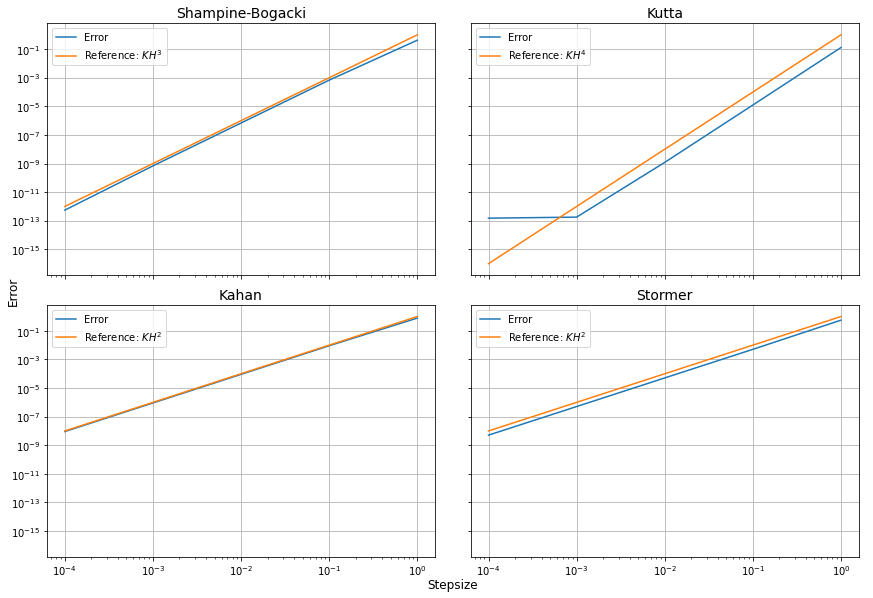

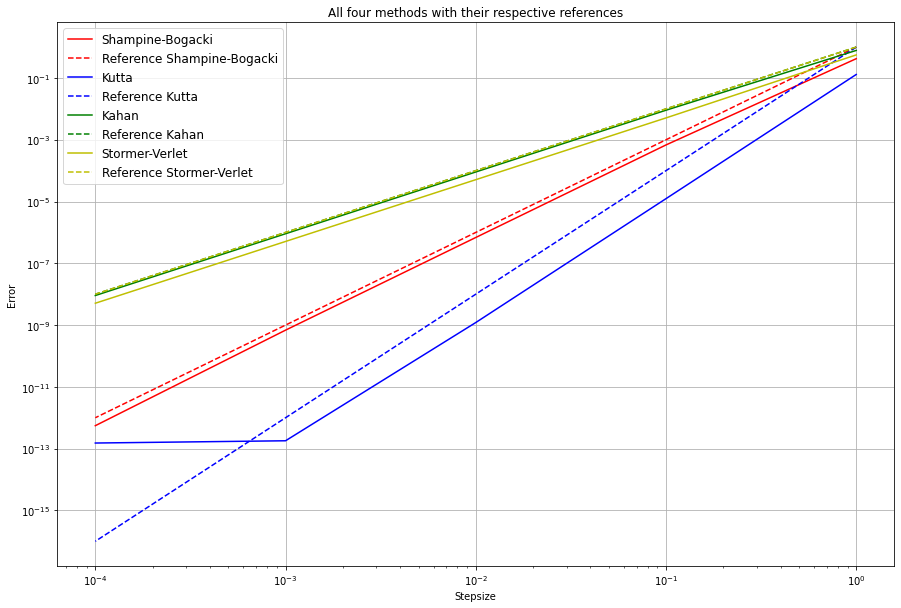

The estimated order of the Shampine Bogacki method: [2.79251875 2.99670186 2.99991312] 

The estimated order of the Runge Kutta method: [4.02006434 4.01099362 3.82798251] 

The estimated order of Kahans method: [1.93593511 1.99955466 1.9999956 ] 

The estimated order of the Störmer-Verlet method: [2.04017115 2.00009355 2.0000009 ] 

These numbers are estimated from three different step sizes and we conclude that they all match the expected values


In [13]:
tol=10**(-14)

#Reference Hénon-Heiles
def henonHeiles(y):
    q1, q2, p1, p2 = y
    return np.array([p1, p2, -q1*(1+2*q2), -q2 - q1**2 + q2**2])

#Required for scipy
def wrapper(t, y):
    return henonHeiles(y)

#Solution to reference
def referenceSolution(t0, tEnd, y0, tol):
    T=(t0, tEnd)
    evaluate=[10]
    yRef=solve_ivp(wrapper, T, y0, method='RK45', rtol=tol, atol=tol).y                             
    return np.transpose(yRef)

#Code for error and order estimation

def convergenceCheck(method, y0, t0, tEnd, f, y_reference, r, s):
    h=np.logspace(r, -s, 5)   #Chose 5 values as its easy to work with
    pEst=np.zeros(len(h)-2)
    error=np.zeros_like(h)
    for i in range(len(h)):
        y_method=method(y0, h[i], f, t0, tEnd)
        #Chose to compute the relative error
        error[i]=np.linalg.norm(y_reference[-1, :]-y_method[:, -1])/np.linalg.norm(y_reference[-1, :])
        if 0<i<len(h)-1:
            pEst[i-1]=(np.log(error[i]/error[i-1]))/(np.log(h[i]/h[i-1])) #Estimating order
    return h, error, pEst


#Finding a solution to our reference
yRef=referenceSolution(0, 10, y0, tol)

#Collecting results 
hSB, errorSB, pEstimatedSB= convergenceCheck(shampine, y0, 0, 10, F, yRef, 0, 4)
hRK, errorRK, pEstimatedRK= convergenceCheck(kutta4, y0, 0, 10, F, yRef, 0, 4)
hCK, errorCK, pEstimatedCK= convergenceCheck(kahans, y0, 0, 10, kahansF, yRef, 0, 4)
hSV, errorSV, pEstimatedSV= convergenceCheck(StormerVerlet, y0, 0, 10, fStormer, yRef, 0, 4)

#Making these lists to simplify plotting
errorInputs=[errorSB, errorRK, errorCK, errorSV]
errorNames=["Shampine-Bogacki", "Kutta", "Kahan", "Stormer"]
order=[3, 4, 2, 2]

#Plotting using subplots
K=1
h =hSV
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize = (12,8), sharex=True, sharey=True)
plt.tight_layout(h_pad = 2, w_pad = 2)

ax1.set_title(f"{errorNames[0]}", fontsize = 14)
ax1.loglog(hSV,errorInputs[0], label = "Error")
ax1.loglog(h,K*h**order[0], label = f"Reference: $KH^{order[0]}$")
ax1.legend()
ax1.grid()

ax2.set_title(f"{errorNames[1]}", fontsize = 14)
ax2.loglog(hSV,errorInputs[1], label = "Error")
ax2.loglog(h,K*h**order[1], label = f"Reference: $KH^{order[1]}$")
ax2.legend()
ax2.grid()

ax3.set_title(f"{errorNames[2]}", fontsize = 14)
ax3.loglog(hSV,errorInputs[2], label = "Error")
ax3.loglog(h,K*h**order[2], label = f"Reference: $KH^{order[2]}$")
ax3.legend()
ax3.grid()

ax4.set_title(f"{errorNames[3]}", fontsize = 14)
ax4.loglog(hSV,errorInputs[3], label = "Error")
ax4.loglog(h,K*h**order[3], label = f"Reference: $KH^{order[3]}$")
ax4.legend()
ax4.grid()


fig.add_subplot(111, frameon=False)
plt.xlabel("Stepsize", fontsize = 12)
plt.ylabel("Error", fontsize = 12)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.show()

#Plotting all error estimates in one plot
plt.figure(figsize = (15,10))
plt.title("All four methods with their respective references")
plt.loglog(hSV, errorInputs[0], color = "r", label = "Shampine-Bogacki")
plt.loglog(hSV, 1*hSV**order[0], '--', color = "r", label = "Reference Shampine-Bogacki")
plt.loglog(hSV, errorInputs[1], color = "b", label = "Kutta")
plt.loglog(hSV, 1*hSV**order[1], '--',color = "b", label = "Reference Kutta")
plt.loglog(hSV, errorInputs[2], color = "g", label = "Kahan")
plt.loglog(hSV, 1*hSV**order[2], '--',color = "g", label = "Reference Kahan")
plt.loglog(hSV, errorInputs[3], color = "y", label = "Stormer-Verlet")
plt.loglog(hSV, 1*hSV**order[3], '--',color = "y", label = "Reference Stormer-Verlet")#hehe What
plt.grid()
plt.xlabel("Stepsize")
plt.ylabel("Error")
plt.legend(fontsize="large")
plt.show()

#loglogplots(hSV, 1, errorInputs, errorNames, order)
print("The estimated order of the Shampine Bogacki method:", pEstimatedSB, "\n")
print("The estimated order of the Runge Kutta method:", pEstimatedRK, "\n")
print("The estimated order of Kahans method:", pEstimatedCK, "\n")
print("The estimated order of the Störmer-Verlet method:", pEstimatedSV, "\n")
print("These numbers are estimated from three different step sizes and we conclude that they all match the expected values")

Even though all methods seem to line up nicely, it is worth noting that for small h values the Kutta method differs a bit from the reference line. The reason for this is that with such small error values the numerical methods will be compromised by rounding errors in the computer. Along with that the tolerance level of our scipy method will be lower than the actual error, hence presenting another source of error. 

As for the order of convergence approximation the results adequately match the given orders(3, 4, 2, 2). Due to the logarithmic scale the importance is that our numeric solution matches the slope of our reference since this gives the order of convergence. Judging by the plots this seems to be the case.



### Conservation of energy

In Hamiltonian systems, if it does not explicitly depend on time, the energy is conserved$^{[1]}$. This is the case in the assignment and it is important that our numerical methods also conserves energy to a certain degree. The first plot is of all the four methods together, over a timespan of 100s. The two plots show how the energy loss is dependant on the step size h. In the second plot, the timespan is set to 1000000s. This is done to analyze how the energy loss in the first plot would propagate over a longer ammount of time. h = $\frac{1}{1000}$ is not used in the last plot, as the kernel crashes when this is attempted.

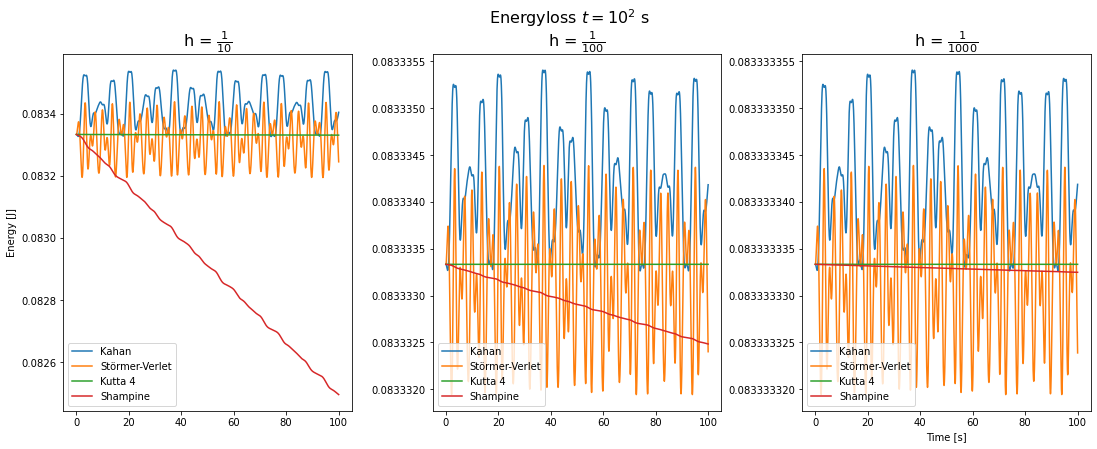

Wall time: 2.69 s


In [14]:
%%time



#Creating the Hamiltonian from each method
@jit(nopython = True)
def Hamiltonian(method, y0, t0, tEnd, f, h):
    yVec=method(y0, h, f, t0, tEnd)
    n = np.int(np.round((tEnd-t0)/h))
    U=np.zeros(n)
    H=np.zeros(n)
    t=np.linspace(t0, tEnd, n)
    for i in range(n):
        #Using given formulas to compute the energy of the system
        U[i]=(yVec[0, i]**2 + yVec[1, i]**2)/2 + ((yVec[0, i]**2)*yVec[1, i] - (yVec[1, i]**3)/3)
        H[i]=(yVec[2, i]**2 + yVec[3, i]**2)/2 + U[i]
    return t, H

#Collecting results for a short timespan and short step size
timestep, EnergySB=Hamiltonian(shampine, y0, 0, 10**2, F, 1/10)
timestep, EnergyRK=Hamiltonian(kutta4, y0, 0, 10**2, F, 1/10)
timestep, EnergyCK=Hamiltonian(kahans, y0, 0, 10**2, kahansF, 1/10)
timestep, EnergySV=Hamiltonian(StormerVerlet, y0, 0, 10**2, fStormer, 1/10)

timestep2, EnergySB2=Hamiltonian(shampine, y0, 0, 10**2, F, 1/100)
timestep2, EnergyRK2=Hamiltonian(kutta4, y0, 0, 10**2, F, 1/100)
timestep2, EnergyCK2=Hamiltonian(kahans, y0, 0, 10**2, kahansF, 1/100)
timestep2, EnergySV2=Hamiltonian(StormerVerlet, y0, 0, 10**2, fStormer, 1/100)

timestep3, EnergySB3=Hamiltonian(shampine, y0, 0, 10**2, F, 1/1000)
timestep3, EnergyRK3=Hamiltonian(kutta4, y0, 0, 10**2, F, 1/1000)
timestep3, EnergyCK3=Hamiltonian(kahans, y0, 0, 10**2, kahansF, 1/1000)
timestep3, EnergySV3=Hamiltonian(StormerVerlet, y0, 0, 10**2, fStormer, 1/1000)



 

#First plot showing a short time development and step sizes h=1/10 and h=1/100
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize = (15,6), sharex=True, sharey=False)
#plt.figure(figsize = (12,10))

ax1.ticklabel_format(useOffset=False) #Choosing not to use offset, since it can be harder to read
plt.suptitle(r"Energyloss $t=10^2$ s", y = 1, fontsize = 16)
plt.tight_layout(h_pad = 5, w_pad = 5)
ax1.plot(timestep, EnergyCK, label = "Kahan")
ax1.plot(timestep, EnergySV, label = "Störmer-Verlet")
ax1.plot(timestep, EnergyRK, label = "Kutta 4")
ax1.plot(timestep, EnergySB, label = "Shampine")
plt.xlabel("Time [s]")
ax1.set_ylabel("Energy [J]")
ax1.set_title(r"h = $\frac{1}{10}$", fontsize = 16)
ax1.legend(loc = "lower left")

ax2.ticklabel_format(useOffset=False)
ax2.plot(timestep2, EnergyCK2, label = "Kahan")
ax2.plot(timestep2, EnergySV2, label = "Störmer-Verlet")
ax2.plot(timestep2, EnergyRK2, label = "Kutta 4")
ax2.plot(timestep2, EnergySB2, label = "Shampine")
ax2.set_title(r"h = $\frac{1}{100}$", fontsize = 16)
ax2.legend(loc = "lower left")

ax3.ticklabel_format(useOffset=False)
ax3.plot(timestep3, EnergyCK3, label = "Kahan")
ax3.plot(timestep3, EnergySV3, label = "Störmer-Verlet")
ax3.plot(timestep3, EnergyRK3, label = "Kutta 4")
ax3.plot(timestep3, EnergySB3, label = "Shampine")
ax3.set_title(r"h = $\frac{1}{1000}$", fontsize = 16)
ax3.legend(loc = "lower left")
plt.show()

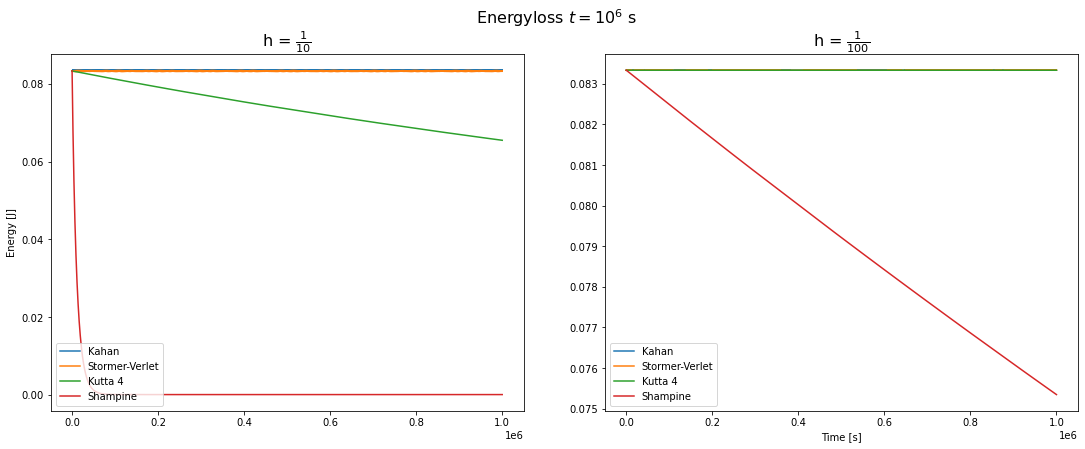

Wall time: 4min 15s


In [18]:
#Note that this code takes some time to run because of the large datasize
%%time


#Collecting results for larger timespan and larger stepsize
#Slicing is used to reduce the ammount of datapoints, since matplotlib will crash if one tries to plot several million points

timestep, EnergySB=np.array(Hamiltonian(shampine, y0, 0, 10**6, F, 1/10))[:,::1000]
timestep, EnergyRK=np.array(Hamiltonian(kutta4, y0, 0, 10**6, F, 1/10))[:, ::1000]
timestep, EnergyCK=np.array(Hamiltonian(kahans, y0, 0, 10**6, kahansF, 1/10))[:, ::1000]
timestep, EnergySV=np.array(Hamiltonian(StormerVerlet, y0, 0, 10**6, fStormer, 1/10))[:, ::1000]


timestep2, EnergySB2=np.array(Hamiltonian(shampine, y0, 0, 10**6, F, 1/100))[:,::1000]
timestep2, EnergyRK2=np.array(Hamiltonian(kutta4, y0, 0, 10**6, F, 1/100))[:, ::1000]
timestep2, EnergyCK2=np.array(Hamiltonian(kahans, y0, 0, 10**6, kahansF, 1/100))[:, ::1000]
timestep2, EnergySV2=np.array(Hamiltonian(StormerVerlet, y0, 0, 10**6, fStormer, 1/100))[:, ::1000]



fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (15,6), sharex=True, sharey=False)
#plt.figure(figsize = (12,10))

ax1.ticklabel_format(useOffset=False) #Choosing not to use offset, since it can be harder to read
plt.suptitle(r"Energyloss $t=10^6$ s", y = 1, fontsize = 16)
plt.tight_layout(h_pad = 5, w_pad = 5)
ax1.plot(timestep, EnergyCK, label = "Kahan")
ax1.plot(timestep, EnergySV, label = "Stormer-Verlet")
ax1.plot(timestep, EnergyRK, label = "Kutta 4")
ax1.plot(timestep, EnergySB, label = "Shampine")
plt.xlabel("Time [s]")
ax1.set_ylabel("Energy [J]")
ax1.set_title(r"h = $\frac{1}{10}$", fontsize = 16)
ax1.legend(loc = "lower left")

ax2.ticklabel_format(useOffset=False)
ax2.plot(timestep2, EnergyCK2, label = "Kahan")
ax2.plot(timestep2, EnergySV2, label = "Stormer-Verlet")
ax2.plot(timestep2, EnergyRK2, label = "Kutta 4")
ax2.plot(timestep2, EnergySB2, label = "Shampine")
ax2.set_title(r"h = $\frac{1}{100}$", fontsize = 16)
ax2.legend(loc = "lower left")
plt.show()

#### Reflection

Discussing these plots there are a few things to consider. Noting that the Shampine and Runge Kutta behaves somewhat similar, and the Kahan and Störmer-Verlet also behaves similar that is what will be discussed. 

We will not discuss in depth the differences of explicit and implicit integration methods, but the fundamental differences is as follows. An explicit method calculates the future state of a system from the current state, while the implicit method solves a different equation from both the next and current state of the system that is used to calculate the future state of the system$^{[7]}$. 

##### Explicit methods
The first two methods, that is Shampine and Runge Kutta, are examples of explicit numerical integration methods$^{[6]}$. Explicit integration carries with it some upsides and downsides that depend on the problem at hand. While the methods are easy to implement and have a short runtime, they are more error-prone over longer periods of time. As we see from the first plot up to $T=100$, the errors are very small and overall more precise than the other methods. However, as soon as we let time develop, we see that the small error grows at the same rate an in the end presents a significant error. 

It is however necessary to separate the methods as the Runge Kutta method is far more precise. This due to the higher order of convergence, causing the global truncation error of the Runge Kutta method to be smaller making it more accurate. 

##### Implicit and symplectic methods
The last two, Kahan and Störmer-Verlet, differ in some ways. Firstly the Kahan method is implicit$^{[1]}$, and for quadratic systems such as ours it is linearly implicit. This means it only needs to solve a system of linear equations in each step making it effective. Furthermore, what makes the Kahan method so accurate over long time spans is that it perturbates the Hamiltonian system and conserves the properties of the perturbated Hamilton. Since the perturbations are small the original and perturbated system are very similar. This makes Kahans method a good numerical integrator for solving Hamiltonian systems over time.

The Störmer Verlet method is what is known as a symplectic integrator. It is not possible for a numerical integration method to both conserve energy and be symplectic for Hamiltonian systems. As a consequence, a perturbated system which resembles the original to great extent. Solutions to this perturbation is found in the symplectc manifold$^{[4]}$ and have certain properties that prove useful. The error in estimation will be exponentially decreasing as time develops and be periodic, resulting in an accurate approximation in which the errors oscillate. Since the simulation runs for a great time span, the Störmer Verlet proves very accurate and oscillates about the initial energy.

##### Step size
The step size h should be considered as well. If one does not consider runtime, the ideal step size is very small, but still large enough to not affect the computers limitations in rounding numbers. Since this would require a lot of computational power over longer timespans, the behavior of the methods at different h-values needs evaluation.

To avoid a confusing notebook we decided to exclude some plots, but the results matter nonetheless. When using a smaller step size the loss of energy in all methods are notably lower as shown above. For $T=10^2s$ and $h=\frac{1}{10}$ we note that the the error in Shampine is in fact greater than all others. For smaller step sizes the explicit methods give a more accurate result but the error quickly becomes large as time develops. The implicit and symplectic methods keep oscillating and also produce better results as time steps grow smaller. 

For even smaller steps, say $h=\frac{1}{1000}$ one all methods give a very precise measure on short periods of time. The downside to such short steps is that one often wishes to study a system over a longer period when it may not be practical with such small steps considering the process and computational resources. This leads to the dilemma of chosing stepsize and timespan while at the same time minimizing error. 

## Poincaré

Poincaré plots are often used to determine how chaotic a system behaves. The chaoticism of an objects movement is intuitively understood as how much a small change in the objects initial conditions would change the overall pattern. The easiest example is a double pendulum in 2D, where a miniscule difference in the initial conditions will after a relatively small amount of time produce two completely different outcomes in the pendulums trajectory, thus making repetition of such an experiment hard to analyze. If one were to make a Poincaré map of such a pendulums movement, it would be a simple line, with dots representing where the pendulum were to cross it. 

In this task however, Poincaré maps are used to identify chaos in a 3D system, with the map being represented by a 2D frame. One example of where this is used is in the analysis of a planet's trajectory. If one were to imagine a 2D frame orthogonally to a planet's trajectory in 3D space, and then analyze at which points the planet were to cross the surface of said 2D frame, one would be able to determine how chaotic the planet's movement was based on how close to each other the points were for each phase. Transeferred to this case, the Poincaré plots could be understood as how well the different methods can approximate a solution to a problem that we know for certain is not chaotic. The degree to which the plots are chaotic shows how much each phase-iteration diverges from the last, and for a function that should be stable, a chaotic solution is a sign of error in the computation.

Shampine: 82.8 seconds
Kutta: 80.548 seconds
Kahan: 85.584 seconds
Stormer-Verlet: 76.024 seconds


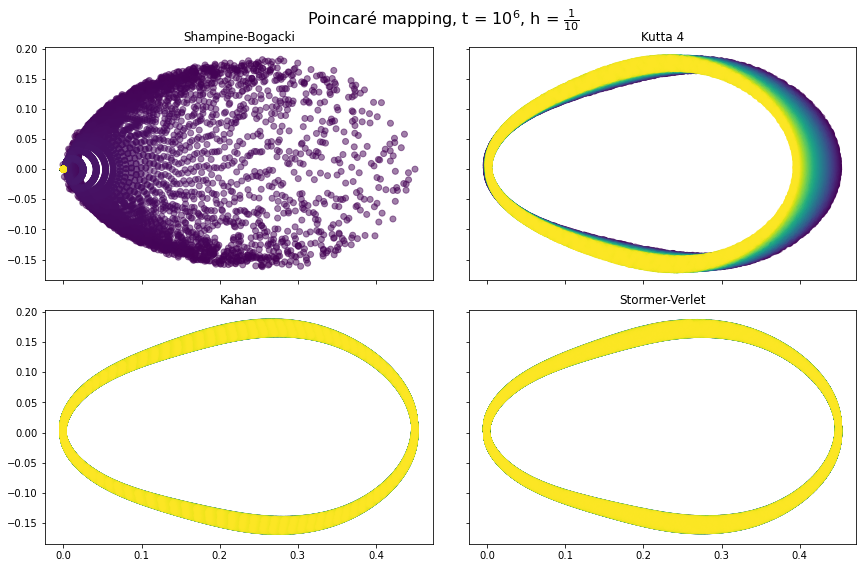

Wall time: 5min 34s


In [16]:
%%time

@jit(nopython= True)
def poincare(method, y0, t0, tEnd, f, h):
    #Collecting and transposing every solution from the input method 
    yMethod=np.transpose(method(y0, h, f, t0, tEnd))
    pointsArr = np.array([[0.45, 0]])
    for i in range(len(yMethod[:,0])-1):
        #Applying conditions to be satisfied
        if (yMethod[i,2]>0) and ((yMethod[i+1,0]>0 and yMethod[i,0]<0) or (yMethod[i+1,0]<0 and yMethod[i,0]>0)):
            #When these are met we use linear interpolation to get more accurate values
            x=np.linspace(yMethod[i,0], yMethod[i+1,0], 100)
            L=x*yMethod[i+1,0] + (1-x)*yMethod[i,0]   #Approaching the x values desirable
            index=np.argmin(np.abs(L))                #Getting the index for that x value
            q2=x[index]*yMethod[i+1, 1] + (1-x[index])*yMethod[i, 1]     #Applying the interpolation
            p2=x[index]*yMethod[i+1, 3] + (1-x[index])*yMethod[i, 3]
            #Storing the more accurate values as our q2 and p2
            pointsArr = np.append(pointsArr, np.array([[q2, p2]]), 0)
    return pointsArr

#Collecting results for a great amount of time and relatively large step size
start = time.time()
PoincaréSB=poincare(shampine, y0, 0, 10**(6), F, 1/10)
print(f"Shampine: {np.round(time.time()-start,3)} seconds")

start = time.time()
PoincaréRK=poincare(kutta4, y0, 0, 10**(6), F, 1/10)
print(f"Kutta: {np.round(time.time()-start,3)} seconds")

start = time.time()
PoincaréCK=poincare(kahans, y0, 0, 10**(6), kahansF, 1/10)
print(f"Kahan: {np.round(time.time()-start,3)} seconds")

start = time.time()
PoincaréSV=poincare(StormerVerlet, y0, 0, 10**(6), fStormer, 1/10)
print(f"Stormer-Verlet: {np.round(time.time()-start,3)} seconds")

c = plt.cm.get_cmap("viridis")

#Plotting with different colors to see development as time passes
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,8), sharex = True, sharey = True)
plt.suptitle(r"Poincaré mapping, t = $10^6$, h = $\frac{1}{10  }$", fontsize = 16)
plt.tight_layout(h_pad = 2, w_pad = 2)
ax1.set_title("Shampine-Bogacki")
ax1.scatter(PoincaréSB[:,0], PoincaréSB[:,1], c = np.linspace(0, 10**6, len(PoincaréSB)), alpha=0.5, cmap = c)
ax2.set_title("Kutta 4")
ax2.scatter(PoincaréRK[:,0], PoincaréRK[:,1], c = np.linspace(0, 10**6, len(PoincaréRK)), alpha=0.5, cmap = c)
ax3.set_title("Kahan")
ax3.scatter(PoincaréCK[:,0], PoincaréCK[:,1], c = np.linspace(0, 10**6, len(PoincaréCK)), alpha=0.5, cmap = c)
ax4.set_title("Stormer-Verlet")
ax4.scatter(PoincaréSV[:,0], PoincaréSV[:,1], c = np.linspace(0, 10**6, len(PoincaréSV)), alpha=0.5, cmap = c)
plt.show()            

Shampine: 106.914 seconds
Kutta: 116.793 seconds
Kahan: 191.098 seconds
Stormer-Verlet: 89.613 seconds


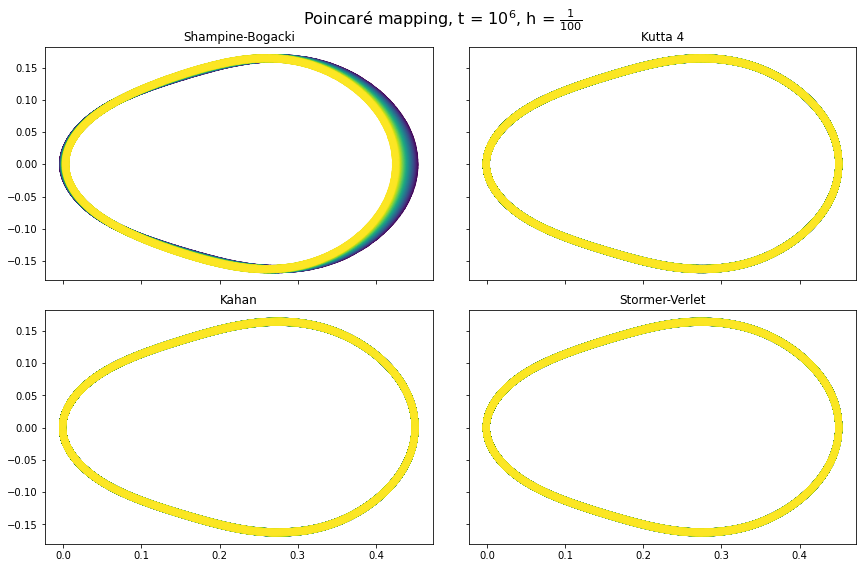

In [17]:
#Note that this code takes some time to run because of the large datasize

#Collecting results for a shorter time development but a smaller step size
start = time.time()
PoincaréSB=poincare(shampine, y0, 0, 10**(6), F, 1/100)
print(f"Shampine: {np.round(time.time()-start,3)} seconds")

start = time.time()
PoincaréRK=poincare(kutta4, y0, 0, 10**(6), F, 1/100)
print(f"Kutta: {np.round(time.time()-start,3)} seconds")

start = time.time()
PoincaréCK=poincare(kahans, y0, 0, 10**(6), kahansF, 1/100)
print(f"Kahan: {np.round(time.time()-start,3)} seconds")

start = time.time()
PoincaréSV=poincare(StormerVerlet, y0, 0, 10**(6), fStormer, 1/100)
print(f"Stormer-Verlet: {np.round(time.time()-start,3)} seconds")

#Scatterplots
c = plt.cm.get_cmap("viridis")

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,8), sharex = True, sharey = True)
plt.suptitle(r"Poincaré mapping, t = $10^6$, h = $\frac{1}{100}$", fontsize = 16)
plt.tight_layout(h_pad = 2, w_pad = 2)
ax1.set_title("Shampine-Bogacki")
ax1.scatter(PoincaréSB[:,0], PoincaréSB[:,1], c = np.linspace(0, 10**6, len(PoincaréSB)), alpha=0.5, cmap = c)
ax2.set_title("Kutta 4")
ax2.scatter(PoincaréRK[:,0], PoincaréRK[:,1], c = np.linspace(0, 10**6, len(PoincaréRK)), alpha=0.5, cmap = c)
ax3.set_title("Kahan")
ax3.scatter(PoincaréCK[:,0], PoincaréCK[:,1], c = np.linspace(0, 10**6, len(PoincaréCK)), alpha=0.5, cmap = c)
ax4.set_title("Stormer-Verlet")
ax4.scatter(PoincaréSV[:,0], PoincaréSV[:,1], c = np.linspace(0, 10**6, len(PoincaréSV)), alpha=0.5, cmap = c)
plt.show()             

Looking at our plots, we note that the Shampine, which is the most error-prone method, will faster turn to chaos. This due to that the errors become large early in the simulation as a result of the loss of energy. As for the other methods we see a clear pattern and the numerical solutions do not stray far from the exact solution. 

However, the width of the Poincare plots can also give an indication of how accurate the method is. The wider the plot the more the numerical method strays from the exact energy. This due to the increase in error as time develops. It is noticeable that the RK method diverges after a substantial amount of time, causing its Poincare plot to be wider than the Kahan and Störmer-Verlet plots. This is predictably because of the miniscule loss of energy found in task 2 has increased to a level at which the error is significant. This is just the case with the lower stepsize, however. For Kahans method and the Störmer-Verlet one could argue that the nice Poincare plots are a consequence of the periodic energy levels that keep the system from turning to chaos. 

As mentioned above regarding step size, it becomes clear in the plots that for a relatively large step size h the explicit methods become more chaotic. This leads to the conclusion that the implicit methods can compute an accurate solution over longer timespans with larger step size than what the explicit methods would require. 

When the step size is small we see that the explicit methods become fairly accurate. This does take longer to run and over such a long timespan the implicit and symplectic methods will be just as accurate. For real life problems such a small step size might often be unrealistic and can not be used.

The last plot displays all methods with a small step size and confirmes our statement that when the sstep size is small all methods give a good result. For this plot we had to adjust time a bit, because of the extra computational power required. 

It is also important to note that the computation used a lot of memory. When we ran the simulation for more than $5*10^6$ seconds, the kernel ran out of memory, and shut down. However this only happened with method C and D, showing that the implicit methods use a lot more of the RAM. This could probably be avoided using better hardware or more optimized code.

### Conclusion

The given task was to analyze convergence, energy conservation and behavior of Hamiltonian systems with four different numerical methods. The two first method were explicit, the third linearly implicit and the last symplectic. What we found is that the implicit and symplectic method were more accurate over longer timespans, while a bit more inaccurate in the short perspective. 
We also notice a clear symmetry between the graphs of energy conservation and Poincaré plots. One can see that the Shampine-Bogacki method loses energy the faster, which is reflected in how the trajectories in the Poincaré plot seem to fall in on themselves. A similar tendency for the Kutta 4 method can be seen, though not to the same degree. We assume that with enough computing power and a long enough timespan or large enough step size we would see similar disorder in the Poincaré plot for the Kutta 4 method. Kahan and Störmer-Verlet conserve energy in a very reliable way, despite not being as precise in energy measurements, which the poincaré mappings reflect this with no apparent deviation from the initial path. 

Concluding that all four methods have their advantages and disadvantages, one must carefully evaluate the problem to be solved. If the simulation does not span out over a great amount of time and one can allow for small step sizes, the explicit methods and especially the RK method should be considered superior. However if the study spans out over time and one wishes to determine the behavior of a system rather than obtain exact calculations in each step, the implicit and symplectic methods prove a better option and give a more accurate result. 

### Sources

1. Project 3 task description 


2. https://link.springer.com/content/pdf/10.1007%2F3-540-30666-8.pdf


3. https://en.wikipedia.org/wiki/Poincar%C3%A9_plot


4. https://en.wikipedia.org/wiki/Symplectic_manifold


5. https://en.wikipedia.org/wiki/Perturbation_(astronomy)


6. https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods


7. https://en.wikipedia.org/wiki/Explicit_and_implicit_methods


8. https://www.youtube.com/watch?v=ENo4dZc1st0 


9. https://www.sciencedirect.com/topics/engineering/poincare-map
